# ConvNet design

In this notebook we will design our own ConvNet and see some existing applications.

We will also see the three different methods to define a Keras model:

- Sequential
- Functional
- Object-Oriented

The goal of this notebook is not to compare models performance, as we are limited on compute power, but to compare model architectures. 

### Dataset loading

In [1]:
from tensorflow.keras import datasets
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
h, w = x_train.shape[1:]

x_train = x_train.reshape(x_train.shape[0], h, w, 1)
x_test = x_test.reshape(x_test.shape[0], h, w, 1)
input_shape = (h, w, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=10000, random_state=42)

(x_train.shape, y_train.shape), (x_val.shape, y_val.shape), (x_test.shape, y_test.shape)

11501568/11490434 [==============================] - 2s 0us/step


(((50000, 28, 28, 1), (50000,)),
 ((10000, 28, 28, 1), (10000,)),
 ((10000, 28, 28, 1), (10000,)))

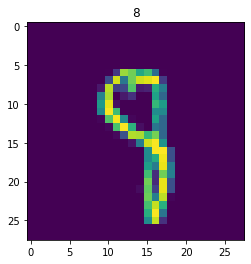

In [2]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0].squeeze(-1))
plt.title(y_train[0]);

In [3]:
import numpy as np

print("{} unique labels.".format(np.unique(y_train)))

[0 1 2 3 4 5 6 7 8 9] unique labels.


## 1. LeNet

Let's define a (slightly modified) LeNet model introduced by Yann Le Cun in 1998 ([paper url](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)). The model is very simple and can be defined with the **Sequential** API.

![lenet archi](images/lenet.png)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, AvgPool2D
from tensorflow.keras import optimizers

lenet = Sequential(name="LeNet-5")

lenet.add(Conv2D(6, kernel_size=(5, 5), activation="tanh", padding="same", input_shape=input_shape, name="C1"))
lenet.add(MaxPool2D(pool_size=(2, 2), name="S2"))
lenet.add(Conv2D(16, kernel_size=(5, 5), activation='tanh', name="C3"))
lenet.add(AvgPool2D(pool_size=(2, 2), name="S4"))
lenet.add(Conv2D(120, kernel_size=(5, 5), activation='tanh', name="C5"))
lenet.add(Flatten())
lenet.add(Dense(84, activation='tanh', name="F6"))
lenet.add(Dense(10, activation='softmax'))

lenet.summary()

Model: "LeNet-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 28, 28, 6)         156       
_________________________________________________________________
S2 (MaxPooling2D)            (None, 14, 14, 6)         0         
_________________________________________________________________
C3 (Conv2D)                  (None, 10, 10, 16)        2416      
_________________________________________________________________
S4 (AveragePooling2D)        (None, 5, 5, 16)          0         
_________________________________________________________________
C5 (Conv2D)                  (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten (Flatten)            (None, 120)               0         
_________________________________________________________________
F6 (Dense)                   (None, 84)                1016

In [5]:
n_epochs = 5
batch_size = 256

lenet.compile(
    optimizer=optimizers.SGD(lr=0.1),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

lenet.fit(
    x_train, y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

C:\Users\Hugo\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/5
196/196 [==============================] - 10s 48ms/step - loss: 0.5974 - accuracy: 0.8415 - val_loss: 0.2565 - val_accuracy: 0.9241
Epoch 2/5
196/196 [==============================] - 9s 47ms/step - loss: 0.2153 - accuracy: 0.9370 - val_loss: 0.1813 - val_accuracy: 0.9438
Epoch 3/5
196/196 [==============================] - 10s 49ms/step - loss: 0.1539 - accuracy: 0.9539 - val_loss: 0.1243 - val_accuracy: 0.9665
Epoch 4/5
196/196 [==============================] - 10s 49ms/step - loss: 0.1209 - accuracy: 0.9642 - val_loss: 0.1147 - val_accuracy: 0.9659
Epoch 5/5
196/196 [==============================] - 9s 47ms/step - loss: 0.1019 - accuracy: 0.9695 - val_loss: 0.0887 - val_accuracy: 0.9756


In [6]:
lenet.evaluate(x_test, y_test, verbose=0)

[0.08096437901258469, 0.9746999740600586]

Note that while LeNet was first defined using either `tanh` or `sigmoid`, those activations are now rarely used. As seen in Lab02, both activations saturate on very small and large values making their gradient almost null.

Now most network use `ReLU` as hidden activation function or one of its derivative (https://keras.io/layers/advanced-activations/).

## 2. Inception

Inception models were introduced in 2014 by Szegedy et al. ([paper url](https://arxiv.org/abs/1409.4842)).

Convolutions have an effective receptive field: the bigger the kernels, and the deeper the model, a features pixel will *see* more image pixels. Read this for a good explanation: [medium blog](https://medium.com/mlreview/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807).

In Inception, convolution kernels of different sizes are combined. Small kernels see small clusters of features (think a detail as an eye) while big kernels see big clusters of features (think a face).

![inception archi](images/inception.png)

This time, use the **Functional** API to define a single Inception layer like the previous image
Exemple usage:

```python
a = Input(shape=(32,))
b = Dense(32)(a)
model = Model(inputs=a, outputs=b)
```

The layer is first instancied (first pair of parenthesis) then called on a tensor (second set of parenthesis).

In [7]:
from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.models import Model


def inception_layer(tensor, n_filters):
    # TODO: define the 4 branches
    branch1x1 = None
    branch5x5 = None
    branch3x3 = None
    branch_pool = None

    # TODO: merge it using Concatenate layer, use Concatenate? for more info
    output = None
    return output


input_tensor = Input(shape=input_shape)
x = Conv2D(16, kernel_size=(5, 5), padding="same")(input_tensor)
x = inception_layer(x, 32)
x = Flatten()(x)
output_tensor = Dense(10, activation="softmax")(x)

mini_inception = Model(inputs=input_tensor, outputs=output_tensor)

mini_inception.summary()

TypeError: Inputs to a layer should be tensors. Got: None

In [9]:
# %load solutions/mini_inception.py
from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.models import Model


def inception_layer(tensor, n_filters):
    branch1x1 = Conv2D(n_filters, kernel_size=(1, 1), activation="relu", padding="same")(tensor)
    branch5x5 = Conv2D(n_filters, kernel_size=(5, 5), activation="relu", padding="same")(tensor)
    branch3x3 = Conv2D(n_filters, kernel_size=(3, 3), activation="relu", padding="same")(tensor)

    branch_pool = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding="same")(tensor)

    output = Concatenate(axis=-1)(
        [branch1x1, branch5x5, branch3x3, branch_pool]
    )
    return output


input_tensor = Input(shape=input_shape)
x = Conv2D(16, kernel_size=(5, 5), padding="same")(input_tensor)
x = inception_layer(x, 32)
x = Flatten()(x)
output_tensor = Dense(10, activation="softmax")(x)

mini_inception = Model(inputs=input_tensor, outputs=output_tensor)

mini_inception.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   416         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   544         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 32)   12832       conv2d_1[0][0]                   
______________________________________________________________________________________________

## 3. ResNet

ResNet (*Residual Networks*) models were introduced by He et al. in 2015 ([paper url](https://arxiv.org/abs/1512.03385)). They found that more layers improved the performance but unfortunatly it was hard to backpropagate the gradients up to first layers.

A trick to let the gradients "*flow*" easily is to use shortcut connection that let the forward tensor untouched (aka a *residual*):

![resnet archi](images/resnet.png)

This time, code a ResNet layer using the **Oriented-Object** API:

Exemple usage:
```python
class MyModel(Model):
    def __init__(self):
        self.classifier = Dense(10, activation="softmax")
        
    def call(self, inputs):
        return self.classifier(inputs)
```

In [ ]:
from tensorflow.keras.layers import Layer, Add


class ResidualBlock(Layer):
    def __init__(self, n_filters):
        super().__init__(name="ResidualBlock")
        
        # TODO: define needed layers, use Add to combine the shortcut with the convs' output.
        
    def call(self, inputs):
        # TODO
        return 42
    

class MiniResNet(Model):
    def __init__(self, n_filters):
        super().__init__()

        self.conv = Conv2D(n_filters, kernel_size=(5, 5), padding="same")
        self.block = ResidualBlock(n_filters)
        self.flatten = Flatten()
        self.classifier = Dense(10, activation="softmax")
        
    def call(self, inputs):
        # TODO
        return 1337


mini_resnet = MiniResNet(32)
mini_resnet.build((None, *input_shape))
mini_resnet.summary()

In [13]:
# %load solutions/mini_resnet.py
from tensorflow.keras.layers import Add, Layer, Activation


class ResidualBlock(Layer):
    def __init__(self, n_filters):
        super().__init__(name="ResidualBlock")

        self.conv1 = Conv2D(n_filters, kernel_size=(3, 3), activation="relu", padding="same")
        self.conv2 = Conv2D(n_filters, kernel_size=(3, 3), padding="same")
        self.add = Add()
        self.last_relu = Activation("relu")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(inputs)

        y = self.add([x, inputs])
        y = self.last_relu(y)

        return y


class MiniResNet(Model):
    def __init__(self, n_filters):
        super().__init__()

        self.conv = Conv2D(n_filters, kernel_size=(5, 5), padding="same")
        self.block = ResidualBlock(n_filters)
        self.flatten = Flatten()
        self.classifier = Dense(10, activation="softmax")

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.block(x)
        x = self.flatten(x)
        y = self.classifier(x)

        return y


mini_resnet = MiniResNet(32)
mini_resnet.build((None, *input_shape))
mini_resnet.summary()


Model: "mini_res_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           multiple                  832       
_________________________________________________________________
ResidualBlock (ResidualBlock multiple                  18496     
_________________________________________________________________
flatten_3 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  250890    
Total params: 270,218
Trainable params: 270,218
Non-trainable params: 0
_________________________________________________________________


## 4. Batch Normalization

Batch Normalization is not an architecture but a layer. Introduced by Ioffe et al. in 2015 ([paper url](https://arxiv.org/abs/1502.03167)). Here is an extract from their abstract:

> Training Deep Neural Networks is complicated by the fact that the **distribution of each layer’s inputs changes during training, as the parameters of the previous layers change**. This slows down the training by requiring lower learningrates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities.  We refer to this phenomenon as **internal covariate shift**, and address the problem by **normalizing layer inputs**.

The results are that ConvNet trained with BatchNorm converge faster and with better results. Nowadays all (or almost all) networks are use it or one of its variants. See this [article on normalization](https://arthurdouillard.com/post/normalization/) for more info.

A classic block is:

In [14]:
class ConvBlock(Layer):
    def __init__(n_filters, kernel_size):
        super().__init__()
        
        self.conv = Conv2D(n_filters, kernel_size=kernel_size, use_bias=False)
        self.bn = BatchNormalization(axis=3)
        self.activation = Activation("relu")
        
    def call(self, inputs):
        return self.activation(
            self.bn(self.conv(inputs))
        )

That you can place multiple times into your network as Lego blocks. 

## 5. Separable Convolutions

ConvNet usually have a lot of parameters because of their large depth. A trick to trim the number of parameters with minimal performance loss is to use **separable convolution**.

The standard convolution has quite a lot of parameters (but still much less than a Fully Connected layer!):

![conv](images/conv.png)

In [15]:
conv_model = Sequential(name="Conv Model")
conv_model.add(Conv2D(8, kernel_size=(3, 3), use_bias=False))

### Exercice: 

- How many parameters does this convolution has?

In [ ]:
# conv_model.build((None, *input_shape))
# conv_model.summary()

Separable convolutions are made of two convolutions:

- A **depthwise convolution**, a single kernel is created per input channels, spatial information is affected, but channels information is not shared

![depthwise conv](images/depthwise.png)

- A **pointwise convolution**, is a usual convolution with a kernel of size (1, 1). Spatial information is not affected, but channels information is shared.

![pointwise conv](images/pointwise.png)

In [16]:
from tensorflow.keras.layers import DepthwiseConv2D

separable_model = Sequential(name="Separable Model")
separable_model.add(DepthwiseConv2D(kernel_size=(3, 3), use_bias=False))
separable_model.add(Conv2D(8, kernel_size=(1, 1), use_bias=False))

### Exercice:

- How many parameters does the Depthwise convolution has?
- How many parameters does the Pointwise convolution has?

In [ ]:
# separable_model.build((None, *input_shape))
# separable_model.summary()

## Home assignments

- See the different models available on Keras: https://keras.io/applications/ What are their different architecture tricks?
- Try to pick an architecture (like [MobileNet](https://arxiv.org/abs/1704.04861) or [Squeeze-and-Excitation network](https://arxiv.org/abs/1709.01507)), read their paper, implement it in Keras, and try to reach good performance on a small dataset like CIFAR10.